https://github.com/VitjanZ/DRAEM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd ./drive/MyDrive/Hanium/Anomaly_detect/

/content/drive/MyDrive/Hanium/Anomaly_detect


### Import Lib

In [3]:
import torch
from torch.utils.data import DataLoader
from torch import optim

from model_unet import ReconstructiveSubNetwork, DiscriminativeSubNetwork
from data_loader import MVTecDRAEMTrainDataset, MVTecDRAEMTestDataset
from loss import FocalLoss, SSIM
from utils import get_lr, weights_init

import os, easydict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Set Parameter 

In [4]:
bs = 4
lr = 1e-4
epochs = 100 #300
start_epoch = 0
data_path = "./datasets/mvtec/"
anomaly_source_path = "./datasets/dtd/images/"
checkpoint_path = "./checkpoints/"
log_path = "./logs/"


obj_batch = [['capsule'], ['bottle'], ['carpet'], ['leather'], ['pill'], ['transistor'], ['tile'], ['cable'],
             ['zipper'], ['toothbrush'], ['metal_nut'], ['hazelnut'], ['screw'], ['grid'], ['wood']]

obj_name = obj_batch[2][0]
run_name = 'DRAEM_test_'+str(lr)+'_'+str(epochs)+'_bs'+str(bs)+"_"+obj_name+'_'

In [5]:
print("Train Class : ", obj_name)

Train Class :  carpet


### Set Dataset

In [6]:
Train_dataset = MVTecDRAEMTrainDataset(data_path + obj_name + "/train/good/", anomaly_source_path, resize_shape=[256, 256])
Test_dataset = MVTecDRAEMTestDataset(data_path + obj_name + "/test/", resize_shape=[256, 256])

Train_dataloader = DataLoader(Train_dataset, batch_size=bs, shuffle=True, num_workers=0)
Test_dataloader = DataLoader(Test_dataset, batch_size=bs, shuffle=True, num_workers=0)

### Visualization Sample

[0.]


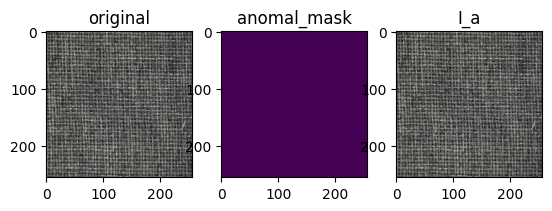

In [7]:
sample = Train_dataset.__getitem__(3)
img, anomaly_mask, augmented_image, has_anomaly, idx = sample.values()
print(has_anomaly)
plt.subplot(1,3,1)
plt.title("original")
plt.imshow(img.transpose(1,2,0))
plt.subplot(1,3,2)
plt.title("anomal_mask")
plt.imshow(anomaly_mask.transpose(1,2,0))
plt.subplot(1,3,3)
plt.title("I_a")
plt.imshow(augmented_image.transpose(1,2,0))
plt.show()

### Set Model

In [8]:
# ReconstructiveSubNetwork
model = ReconstructiveSubNetwork(in_channels=3, out_channels=3)
model.cuda()
model.apply(weights_init);

# DiscriminativeSubNetwork
model_seg = DiscriminativeSubNetwork(in_channels=6, out_channels=2)
model_seg.cuda()
model_seg.apply(weights_init);

### Set Hyperparameters

In [9]:
optimizer = torch.optim.Adam([{"params": model.parameters(), "lr": lr}, {"params": model_seg.parameters(), "lr": lr}])
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,[epochs*0.8,epochs*0.9],gamma=0.2, last_epoch=-1)

In [11]:
loss_l2 = torch.nn.modules.loss.MSELoss()
loss_ssim = SSIM()
loss_focal = FocalLoss()

### Re-train

In [10]:
# 불러오고 적용하기
checkpoint = torch.load('./checkpoints/checkpoint.tar')

model.load_state_dict(checkpoint['model_state_dict'])
model_seg.load_state_dict(checkpoint['model_seg_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = checkpoint['epoch']

In [12]:
model = model.to('cuda')
model_seg = model_seg.to('cuda')

### Train

In [ ]:
new_filename = './logs/model_epoch_200to300.txt'
model_dir = './weights/'

w = open(new_filename, 'w')

for epoch in range(start_epoch, start_epoch + epochs):
    train_loss = 0.
    best_train_loss = 1e3
    val_loss = 0.
    best_val_loss = 1e3
    
    
    model.train()
    model_seg.train()
    for i_batch, sample_batched in enumerate(tqdm(Train_dataloader)):
        # gray_batch : I / aug_gray_batch : I_a / anomaly_mask : M_a
        gray_batch = sample_batched["image"].cuda()
        aug_gray_batch = sample_batched["augmented_image"].cuda()
        anomaly_mask = sample_batched["anomaly_mask"].cuda()

        # gray_rec : I_r / joined_in : I_r + I_a
        gray_rec = model(aug_gray_batch)
        joined_in = torch.cat((gray_rec, aug_gray_batch), dim=1)

        # out_mask_sm : M_a_hat
        out_mask = model_seg(joined_in)
        out_mask_sm = torch.softmax(out_mask, dim=1)

        l2_loss = loss_l2(gray_rec,gray_batch)
        ssim_loss = loss_ssim(gray_rec, gray_batch)

        segment_loss = loss_focal(out_mask_sm, anomaly_mask)
        loss = l2_loss + ssim_loss + segment_loss
        
        # measure
        train_loss += loss.item()

        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
    scheduler.step()
    train_loss = train_loss/len(Train_dataloader)
    
    model.eval()
    model_seg.eval()
    for i_batch, sample_batched in enumerate(tqdm(Test_dataloader)):
        # gray_batch : I / anomaly_mask : M_a (testset에서는 I == I_a 취급)
        gray_batch = sample_batched["image"].cuda()
        true_mask = sample_batched["mask"]
        
        # true_mask_cv = true_mask.detach().numpy()[0,:,:,:].transpose((1, 2, 0))

        # gray_rec : (I + I_r)
        gray_rec = model(gray_batch)
        joined_in = torch.cat((gray_rec.detach(), gray_batch), dim=1)

        # out_mask_sm : M_a_hat
        out_mask = model_seg(joined_in)
        out_mask_sm = torch.softmax(out_mask, dim=1)

        segment_loss = loss_focal(out_mask_sm, true_mask)
        
        # measure
        val_loss += segment_loss.item()

        # out_mask_averaged = torch.nn.functional.avg_pool2d(out_mask_sm[: ,1: ,: ,:], 21, stride=1, padding=21 // 2).cpu().detach().numpy()
        # image_score = np.max(out_mask_averaged)

        # anomaly_score_prediction.append(image_score)

    val_loss = val_loss/len(Test_dataloader)

    if epoch % 1 == 0 :
        print("=====================[{:2d} / {}]=====================".format(epoch, start_epoch + epochs))
        print("train_loss : {:.4f}".format(train_loss))
        print("val_segment_loss : {:.4f}".format(val_loss))
    # train loss = l2 + SSIM + focal_loss, val_loss = focal_loss / reconstruction loss는 anomaly detect 하는데 필요 없기 때문.
    w.write(str(epoch) + ',' + str(round(train_loss, 4)) +  ',' + str(round(val_loss, 4)) + '\n')
w.close()


torch.save({
'model_state_dict': model.state_dict(),
'model_seg_state_dict': model_seg.state_dict(),
'optimizer_state_dict': optimizer.state_dict(),
'scheduler_state_dict': scheduler.state_dict(),
'epoch' : epoch
}, './checkpoints/checkpoint.tar')

100%|██████████| 30/30 [04:03<00:00,  8.13s/it]


=====================[198 / 298]=====================
train_loss : 0.2497
val_segment_loss : 0.0222


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[199 / 298]=====================
train_loss : 0.2397
val_segment_loss : 0.0129


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


=====================[200 / 298]=====================
train_loss : 0.2548
val_segment_loss : 0.0216


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


=====================[201 / 298]=====================
train_loss : 0.2637
val_segment_loss : 0.0182


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


=====================[202 / 298]=====================
train_loss : 0.2427
val_segment_loss : 0.0140


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[203 / 298]=====================
train_loss : 0.2492
val_segment_loss : 0.0131


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


=====================[204 / 298]=====================
train_loss : 0.2483
val_segment_loss : 0.0131


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


=====================[205 / 298]=====================
train_loss : 0.2408
val_segment_loss : 0.0123


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[206 / 298]=====================
train_loss : 0.2617
val_segment_loss : 0.0199


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[207 / 298]=====================
train_loss : 0.2510
val_segment_loss : 0.0114


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


=====================[208 / 298]=====================
train_loss : 0.2472
val_segment_loss : 0.0125


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[209 / 298]=====================
train_loss : 0.2653
val_segment_loss : 0.0134


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


=====================[210 / 298]=====================
train_loss : 0.2592
val_segment_loss : 0.0133


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[211 / 298]=====================
train_loss : 0.2454
val_segment_loss : 0.0121


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


=====================[212 / 298]=====================
train_loss : 0.2542
val_segment_loss : 0.0136


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


=====================[213 / 298]=====================
train_loss : 0.2425
val_segment_loss : 0.0129


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


=====================[214 / 298]=====================
train_loss : 0.2499
val_segment_loss : 0.0122


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[215 / 298]=====================
train_loss : 0.2535
val_segment_loss : 0.0130


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[216 / 298]=====================
train_loss : 0.2522
val_segment_loss : 0.0125


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[217 / 298]=====================
train_loss : 0.2432
val_segment_loss : 0.0126


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[218 / 298]=====================
train_loss : 0.2347
val_segment_loss : 0.0123


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


=====================[219 / 298]=====================
train_loss : 0.2389
val_segment_loss : 0.0139


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[220 / 298]=====================
train_loss : 0.2330
val_segment_loss : 0.0123


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[221 / 298]=====================
train_loss : 0.2383
val_segment_loss : 0.0158


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[222 / 298]=====================
train_loss : 0.2408
val_segment_loss : 0.0131


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[223 / 298]=====================
train_loss : 0.2389
val_segment_loss : 0.0122


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[224 / 298]=====================
train_loss : 0.2545
val_segment_loss : 0.0151


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[225 / 298]=====================
train_loss : 0.2400
val_segment_loss : 0.0132


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[226 / 298]=====================
train_loss : 0.2495
val_segment_loss : 0.0146


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[227 / 298]=====================
train_loss : 0.2427
val_segment_loss : 0.0129


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


=====================[228 / 298]=====================
train_loss : 0.2439
val_segment_loss : 0.0173


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[229 / 298]=====================
train_loss : 0.2385
val_segment_loss : 0.0143


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[230 / 298]=====================
train_loss : 0.2522
val_segment_loss : 0.0173


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


=====================[231 / 298]=====================
train_loss : 0.2700
val_segment_loss : 0.0128


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[232 / 298]=====================
train_loss : 0.2460
val_segment_loss : 0.0128


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[233 / 298]=====================
train_loss : 0.2336
val_segment_loss : 0.0122


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[234 / 298]=====================
train_loss : 0.2367
val_segment_loss : 0.0142


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[235 / 298]=====================
train_loss : 0.2315
val_segment_loss : 0.0148


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[236 / 298]=====================
train_loss : 0.2427
val_segment_loss : 0.0127


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[237 / 298]=====================
train_loss : 0.2335
val_segment_loss : 0.0143


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[238 / 298]=====================
train_loss : 0.2431
val_segment_loss : 0.0143


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[239 / 298]=====================
train_loss : 0.2553
val_segment_loss : 0.0134


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[240 / 298]=====================
train_loss : 0.2290
val_segment_loss : 0.0123


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


=====================[241 / 298]=====================
train_loss : 0.2486
val_segment_loss : 0.0132


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[242 / 298]=====================
train_loss : 0.2394
val_segment_loss : 0.0130


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[243 / 298]=====================
train_loss : 0.2533
val_segment_loss : 0.0130


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


=====================[244 / 298]=====================
train_loss : 0.2305
val_segment_loss : 0.0138


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[245 / 298]=====================
train_loss : 0.2371
val_segment_loss : 0.0135


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[246 / 298]=====================
train_loss : 0.2365
val_segment_loss : 0.0124


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[247 / 298]=====================
train_loss : 0.2490
val_segment_loss : 0.0127


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[248 / 298]=====================
train_loss : 0.2183
val_segment_loss : 0.0146


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[249 / 298]=====================
train_loss : 0.2467
val_segment_loss : 0.0121


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[250 / 298]=====================
train_loss : 0.2445
val_segment_loss : 0.0133


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[251 / 298]=====================
train_loss : 0.2281
val_segment_loss : 0.0134


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[252 / 298]=====================
train_loss : 0.2474
val_segment_loss : 0.0139


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[253 / 298]=====================
train_loss : 0.2436
val_segment_loss : 0.0126


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[254 / 298]=====================
train_loss : 0.2343
val_segment_loss : 0.0130


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[255 / 298]=====================
train_loss : 0.2244
val_segment_loss : 0.0133


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[256 / 298]=====================
train_loss : 0.2443
val_segment_loss : 0.0134


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[257 / 298]=====================
train_loss : 0.2574
val_segment_loss : 0.0159


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[258 / 298]=====================
train_loss : 0.2299
val_segment_loss : 0.0140


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[259 / 298]=====================
train_loss : 0.2335
val_segment_loss : 0.0174


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[260 / 298]=====================
train_loss : 0.2434
val_segment_loss : 0.0135


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[261 / 298]=====================
train_loss : 0.2444
val_segment_loss : 0.0217


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[262 / 298]=====================
train_loss : 0.2253
val_segment_loss : 0.0437


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[263 / 298]=====================
train_loss : 0.2329
val_segment_loss : 0.0214


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


=====================[264 / 298]=====================
train_loss : 0.2288
val_segment_loss : 0.0303


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[265 / 298]=====================
train_loss : 0.2454
val_segment_loss : 0.0239


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[266 / 298]=====================
train_loss : 0.2378
val_segment_loss : 0.0231


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[267 / 298]=====================
train_loss : 0.2402
val_segment_loss : 0.0153


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[268 / 298]=====================
train_loss : 0.2277
val_segment_loss : 0.0156


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


=====================[269 / 298]=====================
train_loss : 0.2449
val_segment_loss : 0.0132


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[270 / 298]=====================
train_loss : 0.2292
val_segment_loss : 0.0136


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


=====================[271 / 298]=====================
train_loss : 0.2384
val_segment_loss : 0.0225


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[272 / 298]=====================
train_loss : 0.2288
val_segment_loss : 0.0195


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


=====================[273 / 298]=====================
train_loss : 0.2435
val_segment_loss : 0.0142


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


=====================[274 / 298]=====================
train_loss : 0.2370
val_segment_loss : 0.0126


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[275 / 298]=====================
train_loss : 0.2413
val_segment_loss : 0.0165


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


=====================[276 / 298]=====================
train_loss : 0.2437
val_segment_loss : 0.0220


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[277 / 298]=====================
train_loss : 0.2391
val_segment_loss : 0.0131


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[278 / 298]=====================
train_loss : 0.2299
val_segment_loss : 0.0256


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


=====================[279 / 298]=====================
train_loss : 0.2430
val_segment_loss : 0.0159


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[280 / 298]=====================
train_loss : 0.2325
val_segment_loss : 0.0142


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[281 / 298]=====================
train_loss : 0.2353
val_segment_loss : 0.0131


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[282 / 298]=====================
train_loss : 0.2269
val_segment_loss : 0.0151


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[283 / 298]=====================
train_loss : 0.2332
val_segment_loss : 0.0134


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[284 / 298]=====================
train_loss : 0.2241
val_segment_loss : 0.0144


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[285 / 298]=====================
train_loss : 0.2342
val_segment_loss : 0.0140


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[286 / 298]=====================
train_loss : 0.2282
val_segment_loss : 0.0143


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[287 / 298]=====================
train_loss : 0.2278
val_segment_loss : 0.0133


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[288 / 298]=====================
train_loss : 0.2275
val_segment_loss : 0.0209


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[289 / 298]=====================
train_loss : 0.2309
val_segment_loss : 0.0222


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[290 / 298]=====================
train_loss : 0.2366
val_segment_loss : 0.0186


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[291 / 298]=====================
train_loss : 0.2371
val_segment_loss : 0.0213


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


=====================[292 / 298]=====================
train_loss : 0.2444
val_segment_loss : 0.0133


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


=====================[293 / 298]=====================
train_loss : 0.2407
val_segment_loss : 0.0151


100%|██████████| 30/30 [00:15<00:00,  1.97it/s]


=====================[294 / 298]=====================
train_loss : 0.2455
val_segment_loss : 0.0175


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


=====================[295 / 298]=====================
train_loss : 0.2304
val_segment_loss : 0.0123


100%|██████████| 30/30 [00:15<00:00,  1.97it/s]


=====================[296 / 298]=====================
train_loss : 0.2283
val_segment_loss : 0.0127


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


=====================[297 / 298]=====================
train_loss : 0.2344
val_segment_loss : 0.0148
